# A Building Aid for the Events’ Daily Logbook

### Data Science Correlation-One - DS4A/2020
### Team 13 

<table><tr>
    <td>Randy Steven Consuegra Ortega</td>
    <td>Lina Marcela García Moreno</td>
    </tr>
    <tr>
    <td>Wilfredo Alfonso Morales</td>
    <td>Edgar Andrade Lotero</td>
    </tr>
    <tr>
    <td>Mario Julián Mora Cardona</td>
    <td>Sebastian Jimenez Parra</td>
    </tr>
    <tr>
    <td>Hernán David Carvajal Bastidas</td>
</tr></table>

### Project Description

The Victims' Unit (VU) is an institution responsible for issuing caring, assistance, and atonement measures in regards to victims from the internal armed conflict. To improve humanitarian emergency intervention from the State, VU's professional staff update an Events' Daily Logbook (EDL) by manually identifying, collecting, and categorizing events related to the armed conflict's violence dynamics reported in national and local news broadcasts. VU has sought support in Data Science to extract contextual information and categorize actions victimizing the civilian population. In this context, a Machine Learning tool that collects digital news and relates it to a probability of categorization in some of the victimizing events will prove most useful. Professionals in charge of checking the informative services could significantly reduce the time invested in these activities, expanding their availability to support decision-making processes in the implementation of public policy and improving the State's opportunity to address humanitarian emergencies.

In [149]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from unidecode import unidecode
from wordcloud import WordCloud

#if is the first time that you use nltk, please uncomment the following
#two lines and execute it.
#import nltk
#nltk.download('stopwords')

pd.options.display.max_columns = None

sns.set()

**Brief description of the preliminary data**

The dataset described here was scraped from the website of a number of newspapers, and it is only a preliminary one to be complemented in the upcoming weeks.

In [108]:
cnx = sqlite3.connect('data.db')

df = pd.read_sql_query("SELECT * FROM news", cnx)
df['fecha_publicacion'] = pd.to_datetime(df['fecha_publicacion'])

df.head(2)

,titulo,cuerpo,fecha_publicacion,diario,url,page
0,Campesino asesinado en Baraya,Un impacto en el pecho con una escopeta calibr...,2020-06-11 17:00:33,lanacion,https://www.lanacion.com.co/campesino-asesinad...,2
1,‘Morcilla’ a responder por homicidio de un jov...,Jorge Leonardo Pájaro Paredes conocido como ‘M...,2020-06-10 10:10:56,lanacion,https://www.lanacion.com.co/morcilla-a-respond...,2


In [109]:
df.groupby('diario').agg({'url': 'size','fecha_publicacion': ['min', 'max']})

url   fecha_publicacion                    
                        size                 min                 max
diario                                                              
diariodelhuila            46 2020-04-21 00:00:00 2020-06-12 00:00:00
eldiario                1319 2019-01-31 19:51:59 2020-06-12 00:00:43
elnuevodia               446 2020-01-13 11:02:33 2020-06-10 16:59:23
elpais                   140 2020-05-03 00:00:00 2020-06-12 00:00:00
hoydiariodelmagdalena   3713 2019-07-07 08:24:45 2020-06-12 17:43:36
lanacion               13323 2012-01-02 06:11:58 2020-06-11 17:00:33

**Brief word frequency analysis per news**

We have obtained simple descriptive statistics concerning the word count of each news.

In [110]:
df['long_cuerpo'] = df['cuerpo'].apply(lambda x: len(str(x).split()))
df['long_cuerpo'].value_counts().sort_values()

1527       1
1146       1
1130       1
970        1
922        1
        ... 
174       73
204       74
189       75
54        77
55      1174
Name: long_cuerpo, Length: 1091, dtype: int64

In [111]:
df['long_cuerpo'].describe()

count    18987.000000
mean       282.248749
std        199.299649
min          0.000000
25%        159.000000
50%        240.000000
75%        353.000000
max       3790.000000
Name: long_cuerpo, dtype: float64

News with very few words don't do, so we drop them out of the dataset.

In [116]:
df = df[df['long_cuerpo']!=0]
df['long_cuerpo'].describe()

count    18918.000000
mean       283.278201
std        198.931128
min          3.000000
25%        160.000000
50%        240.500000
75%        353.750000
max       3790.000000
Name: long_cuerpo, dtype: float64

In [164]:
df.shape

(18918, 8)

We investigate news with 10 words.

In [123]:
n_words = 10
df2 = df.query('long_cuerpo<@n_words')
N = df2.shape[0]
print('Number of news with less than', n_words, 'words:', N)

def show_news(n, df):
    print(
        "Titulo:", df['titulo'].iloc[n],
        "\nNumero palabras:", df['long_cuerpo'].iloc[n],
        "\nDiario:", df['diario'].iloc[n],
        "\nCuerpo:", df['cuerpo'].iloc[n],

        "\nurl:", df['url'].iloc[n],
    )
    
show_news(1, df2)

Number of news with less than 10 words: 3
Titulo: Falleció motociclista accidentado el pasado domingo 
Numero palabras: 3 
Diario: lanacion 
Cuerpo: Llevaba la vía 
url: https://www.lanacion.com.co/fallecio-motociclista-accidentado-el-pasado-domingo/


In the news' body there are only three words, but checking the link we find that the scraper requires refinement, since it didn't quite scraped the news:

![](motociclista.png)

We take a look now at the entire distribution:

Text(0, 0.5, 'Number of news')

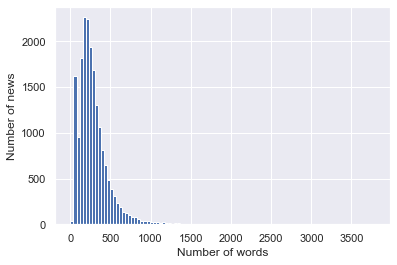

In [115]:
fig, ax = plt.subplots()
df['long_cuerpo'].plot.hist(bins=100)
ax.set_xlabel("Number of words")
ax.set_ylabel("Number of news")

The distribution of numbers of words per news has a heavy right tail. This is to be expected. Surprisingly, however, there is a peak to the left of the distribution that deserves closer scrutiny.

Text(0, 0.5, 'Number of news')

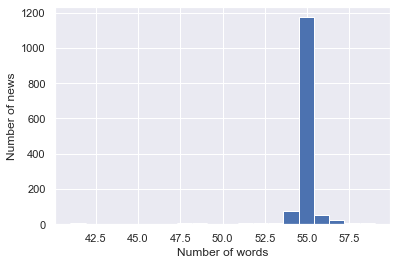

In [65]:
df1 = df[(df['long_cuerpo'] > 40) & (df['long_cuerpo'] < 60)]
fig, ax = plt.subplots()
df1['long_cuerpo'].plot.hist(bins=20)
ax.set_xlabel("Number of words")
ax.set_ylabel("Number of news")
#ax.set_xlim([40,60])

We explore some news with 55 words.

In [91]:
df2 = df.query('long_cuerpo==55')
   
show_news(0, df2)

Titulo: Lucharon contra el tiempo para salvarlas, pero no se pudo 
Numero palabras: 55 
Diario: eldiario 
Cuerpo: El reporte de las autoridades indica que fueron alrededor de 13 las personas heridas, Una tragedia inesperada causó impotencia entre quienes pusieron todas sus fuerzas para evitar la muerte de dos personas; este hecho ocurrió en la entrada al municipio de La Virginia después de pasar el puente Francisco Jaramillo Ochoa.  De las causas del… 
url: https://www.eldiario.com.co/judicial/editorwebeldiario-com-co/lucharon-contra-el-tiempo-para-salvarlas-pero-no-se-pudo/


We want to investigate if the peak is caused by news having `...`

Text(0, 0.5, 'Number of news')

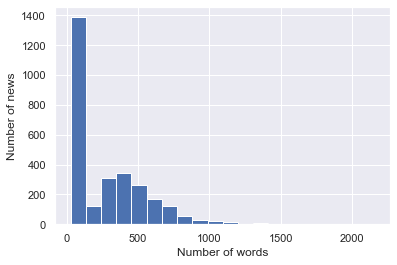

In [93]:
df['cuerpo'].str.contains('…').sum()
df1 = df[df['cuerpo'].str.contains('…')]
fig, ax = plt.subplots()
df1['long_cuerpo'].plot.hist(bins=20)
ax.set_xlabel("Number of words")
ax.set_ylabel("Number of news")

In [94]:
df2 = df1.query('long_cuerpo>1000')

In [95]:
show_news(0, df2)

Titulo: ‘Mató a la exesposa y la trozó en pedacitos’ 
Numero palabras: 1245 
Diario: lanacion 
Cuerpo: Rafael Rodríguez C. rafael@lanacion. com. co “La intención era que nunca se conociera dónde estaba Miriam, que se diera por desaparecida…la trozo en pedacitos…”, fue la cruda narración de la Fiscal Tercera Especializada de Neiva, al señalar como presunto responsable del macabro asesinato de Miriam Ovalle Téllez a su exesposo Hermes Cabrera Pascuas. Las sospechas, de los investigadores del Gaula de la Policía en el Huila, sobre la presunta autoría del hombre en el crimen, se hicieron más fuertes no solo con el análisis de los videos de las cámaras de establecimientos comerciales donde se ve a la pareja, sino por las inconsistencias en sus declaraciones, por los rastros de sangre que se encontraron en el vehículo y el análisis del perfilador criminal de la Dijin. “Hay muchas inconsistencias en referencia a lo manifestado por Hermes Cabrera, quien fue la última persona en tener contacto 

The caracter `...` can show up also in the middle of a textual quote. However, we can check only at the end of the news.

In [98]:
df2 = df[df['cuerpo'].str.endswith('…')]
show_news(0, df2)

Titulo: Recién nacido fue encontrado dentro de una bolsa plástica 
Numero palabras: 49 
Diario: lanacion 
Cuerpo: Las autoridades se encuentran realizando las debidas diligencias para esclarecer quién dejó abandonada una bolsa plástica que contenía en su interior a un bebé recién nacido. El hecho ocurrió este domingo en la calle 27 sur # 34A – 74 del barrio Oasis 3 de Neiva. Noticia en desarrollo… 
url: https://www.lanacion.com.co/recien-nacido-fue-encontrado-dentro-de-una-bolsa-plastica/


(45.0, 60.0)

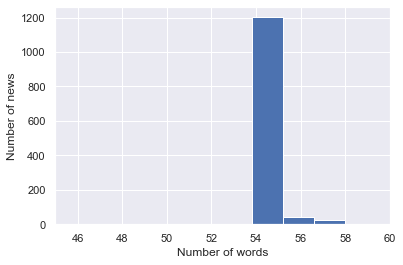

In [106]:
fig, ax = plt.subplots()
df2['long_cuerpo'].plot.hist(bins=200)
ax.set_xlabel("Number of words")
ax.set_ylabel("Number of news")
ax.set_xlim([45,60])

We take a look now at the distribution per newspaper:

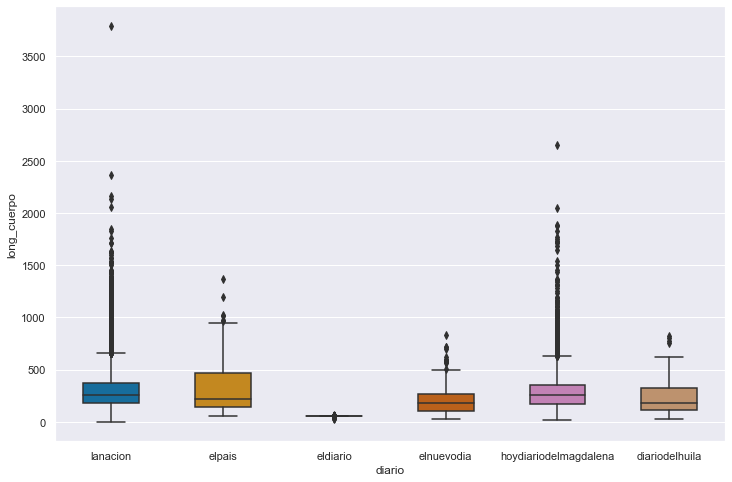

In [127]:
plt.figure(figsize=(12, 8))
sns.boxplot(
    y='long_cuerpo', 
    x='diario', 
    data=df, 
    width=0.5, 
    palette="colorblind"
)

In [130]:
eldiario_df = df.query('diario=="eldiario"')
eldiario_df['long_cuerpo'].value_counts()

55    1168
54      68
56      42
57      23
41       2
58       2
53       2
40       2
61       1
33       1
38       1
39       1
44       1
42       1
43       1
59       1
48       1
26       1
Name: long_cuerpo, dtype: int64

In [131]:
show_news(0, eldiario_df)

Titulo: Lucharon contra el tiempo para salvarlas, pero no se pudo 
Numero palabras: 55 
Diario: eldiario 
Cuerpo: El reporte de las autoridades indica que fueron alrededor de 13 las personas heridas, Una tragedia inesperada causó impotencia entre quienes pusieron todas sus fuerzas para evitar la muerte de dos personas; este hecho ocurrió en la entrada al municipio de La Virginia después de pasar el puente Francisco Jaramillo Ochoa.  De las causas del… 
url: https://www.eldiario.com.co/judicial/editorwebeldiario-com-co/lucharon-contra-el-tiempo-para-salvarlas-pero-no-se-pudo/


News with this amount of words seem to be from newspapers requiring subscription:

![](suscription.png)

In [134]:
%%html
<iframe src="https://www.eldiario.com.co/judicial/editorwebeldiario-com-co/roba-desde-los-15-anos/" width="500" height="500"></iframe>

Which newspapers have "breaking news" and or require suscription?

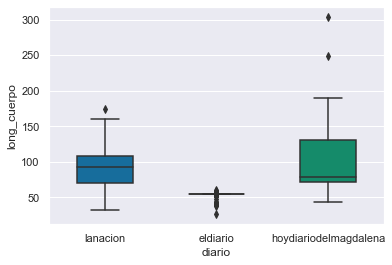

In [135]:
sns.boxplot(
    y='long_cuerpo', 
    x='diario', 
    data=df[df['cuerpo'].str.endswith('…')], 
    width=0.5, 
    palette="colorblind"
)

**Preliminary conclusion 1**

- We need to verify the code from some scrapers which are not scrapping the news' body.

- There is a high number of news which are either "breaking news" (containing but a few informative words) or news which cannot be fully accessed since they require suscription (these also provide but a few words). We decided not to discard these news from our analysis.

**Text mining**

We clean up words

In [151]:
swords = stopwords.words('spanish')
df_names = pd.read_csv('names.csv')

swords = swords + list(df_names['name'])
print('size words dictionary to remove', len(swords))

size words dictionary to remove 5652


In [152]:
spanishstemmer = SnowballStemmer('spanish')

In [153]:
df['text'] = df['titulo'] + ' ' + df['cuerpo']

# 
serie_word = df['text']

print('Convirtiendo a minuscula...')
#Lower case
serie_word = serie_word.str.lower()

print('Removiendo puntuacion...')
#Removing Punctuation
serie_word = serie_word.str.replace('[^\w\s]','')

print('Removiendo stopwords...')
#Removal of Stop Words
#pattern = '|'.join(swords)
serie_word = serie_word.apply(lambda x: " ".join(word for word in x.split() if word not in swords))

print('Removiendo acentos...')
#Removal accents
serie_word = serie_word.apply(lambda x: " ".join(unidecode(word) for word in x.split()))

print('Removiendo numeros...')
#Numbers removing
serie_word = serie_word.str.replace('\d+', '')

print('Stemming words...')
# Stemming (word root)
serie_word = serie_word.apply(lambda x: " ".join(spanishstemmer.stem(word) for word in x.split()))

print('Validando si la palabra es del alfabeto')
serie_word = serie_word.apply(lambda x: " ".join(word for word in x.split() if word.isalpha()))

print('Si tiene mas de dos letras')
serie_word = serie_word.apply(lambda x: " ".join(word for word in x.split() if len(word) > 2))


# number words by each body
serie_word.apply(lambda x: len(x))

serie_word.apply(lambda x: len(x)).sum()


Convirtiendo a minuscula...
Removiendo puntuacion...
Removiendo stopwords...
Removiendo acentos...
Removiendo numeros...
Stemming words...
Validando si la palabra es del alfabeto
Si tiene mas de dos letras


17577089

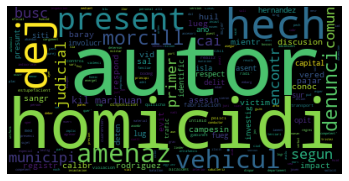

In [154]:
text = serie_word.values
wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**Inside the news from a word frequency perspective**

Our preliminary analysis considers a simple frequency of keywords. We choose the words describing subcategories from one of the main categories of interest in Victim's Unit, namely, "Hechos contra la población civil".

In [155]:
# Keep only news containing relevant keywords
searchfor = ["homicidio",
"masacre", "secuestro",
"tortura",
"desplazamiento",
"forzado",
"confinamiento",
"accidente minas",
"antipersonal",
"atentado",
"reclutamiento",
#"utilizacion NNA",
"violencia sexual",
"ataque",
"indiscriminado",
"ataque bienes",
"civiles"]

searchfor = pd.Series(searchfor)

print('Stemming words...')
# Stemming (word root)
searchfor = searchfor.apply(lambda x: " ".join(spanishstemmer.stem(word) for word in x.split()))

Stemming words...


In [158]:
searchfor

0            homicidi
1              masacr
2            secuestr
3              tortur
4             desplaz
5                forz
6              confin
7        accident min
8        antipersonal
9               atent
10             reclut
11    violenci sexual
12              ataqu
13        indiscrimin
14         ataqu bien
15              civil
dtype: object

In [159]:
searchfor = list(searchfor)
db_hechocontrapoblacion=serie_word[serie_word.str.contains('|'.join(searchfor))]

# Count frequency of occurrence of each keyword in these news
vectorizer = CountVectorizer(vocabulary=searchfor, min_df=0,
                             stop_words=frozenset(), token_pattern=r"(?u)\b\w+\b")
X = vectorizer.fit_transform(db_hechocontrapoblacion.values)
result = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names())
result

,homicidi,masacr,secuestr,tortur,desplaz,forz,confin,accident min,antipersonal,atent,reclut,violenci sexual,ataqu,indiscrimin,ataqu bien,civil
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,2,2,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6515,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
6516,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6517,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6518,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [162]:
result.describe().T

,count,mean,std,min,25%,50%,75%,max
homicidi,6520.0,0.698926,1.150708,0.0,0.0,0.0,1.0,11.0
masacr,6520.0,0.038497,0.395041,0.0,0.0,0.0,0.0,13.0
secuestr,6520.0,0.377914,1.395038,0.0,0.0,0.0,0.0,15.0
tortur,6520.0,0.036656,0.301919,0.0,0.0,0.0,0.0,9.0
desplaz,6520.0,0.219632,0.514774,0.0,0.0,0.0,0.0,6.0
forz,6520.0,0.046319,0.275282,0.0,0.0,0.0,0.0,5.0
confin,6520.0,0.007822,0.116581,0.0,0.0,0.0,0.0,3.0
accident min,6520.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
antipersonal,6520.0,0.010429,0.159233,0.0,0.0,0.0,0.0,5.0
atent,6520.0,0.400307,0.980028,0.0,0.0,0.0,0.0,13.0


**Preliminary conclusion 2**

- Out of 18918 news, 6520 of them contain at least one of the keywords from the relevant category ("Events against civilian population").

- "Homicidio", "Atentado", "Ataque and "Secuestro"